# CA3-like Network: Sequence Encoding and Replay

## Introduction

This notebook models the core computational phenomenon that makes hippocampal
sharp-wave ripples (SWRs) scientifically important: **memory replay**.

During waking exploration, hippocampal CA3 neurons fire in temporal sequences —
place cells activate in the order corresponding to locations along a path.
During subsequent sleep or quiet wakefulness, these sequences **re-emerge
spontaneously** within SWR events, compressed ~20x in time. This is thought to
be the mechanism by which the hippocampus transfers memories to the neocortex.

**This notebook models:**
1. **Encoding** — sequential stimulation imprints a preferred firing order
2. **Hebbian weights** — asymmetric E→E connections encode the sequence
3. **Replay** — a sharp-wave input triggers reactivation in the same order
4. **Analysis** — rank-order correlation to quantify replay fidelity

What circuit mechanisms in CA3 generate the sharp-wave ripples that drive
replay, and how do E-I interactions support memory consolidation?

## Model
We extend the E-I LIF network from Notebook 2 with:
- **Asymmetric E→E weight matrix** encoding a temporal sequence
- **Three simulation phases**: encoding, rest, replay
- **Spearman rank correlation** to measure replay fidelity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import welch
from scipy.stats import spearmanr

np.random.seed(42)

# ── Network ────────────────────────────────────────────────────────────────────
N_E = 400
N_I = 100
N   = N_E + N_I

N_GROUPS   = 10               # sequence groups (like place fields)
GROUP_SIZE = N_E // N_GROUPS  # 40 neurons per group

# ── LIF parameters (verified in Notebook 2) ───────────────────────────────────
tau_m   = 20.0
V_rest  = -70.0
V_th    = -54.0
V_reset = -70.0
t_ref   = 2.0
tau_E   = 5.0
tau_I   = 10.0
dt      = 0.1
t_ref_steps = int(t_ref / dt)
decay_E = np.exp(-dt / tau_E)
decay_I = np.exp(-dt / tau_I)

# ── Background drive (from Notebook 2) ───────────────────────────────────────
bg_rate_E = 5000.0
bg_rate_I = 200.0
w_bg_E    = 0.65
w_bg_I    = 0.65
p_bg_E    = bg_rate_E * dt / 1000.0
p_bg_I    = bg_rate_I * dt / 1000.0

# ── Network weights ───────────────────────────────────────────────────────────
w_EI = 2.0
w_IE = 0.5
w_II = 0.3

# ── Simulation timing ─────────────────────────────────────────────────────────
T           = 1200.0
t_steps     = int(T / dt)
t_arr       = np.arange(t_steps) * dt
dur_s       = T / 1000.0

T_ENC_START = 50.0
T_ENC_END   = 450.0
STIM_DUR    = 30.0
STIM_GAP    = (T_ENC_END - T_ENC_START - N_GROUPS * STIM_DUR) / (N_GROUPS - 1)
T_SWR_START = 800.0
T_SWR_END   = 860.0
STIM_AMP    = 4.0
SWR_RATE    = 2000.0

group_onsets = [T_ENC_START + g * (STIM_DUR + STIM_GAP) for g in range(N_GROUPS)]

print(f'Network: {N_E} E + {N_I} I = {N} neurons')
print(f'Sequence: {N_GROUPS} groups of {GROUP_SIZE} neurons')
print(f'Encoding: {T_ENC_START:.0f}–{T_ENC_END:.0f} ms  |  '
      f'Rest: {T_ENC_END:.0f}–{T_SWR_START:.0f} ms  |  '
      f'SWR: {T_SWR_START:.0f}–{T_SWR_END:.0f} ms')

Network: 400 E + 100 I = 500 neurons
Sequence: 10 groups of 40 neurons
Encoding: 50–450 ms  |  Rest: 450–800 ms  |  SWR: 800–860 ms


## 2. Asymmetric Synaptic Weight Matrix

We apply a simplified **spike-timing-dependent plasticity (STDP)** rule:
neurons that fired earlier (during encoding) develop **stronger forward
connections** to neurons that fired later. This asymmetry biases activity
propagation in the forward direction during replay.

$$w_{ij} = \begin{cases}
w_{\text{fwd}} & \text{if group}(i) < \text{group}(j) \text{ (forward, nearby)} \\
w_{\text{back}} & \text{if group}(i) > \text{group}(j) \text{ (backward)} \\
w_{\text{within}} & \text{if group}(i) = \text{group}(j) \\
w_{\text{base}} & \text{otherwise}
\end{cases}$$

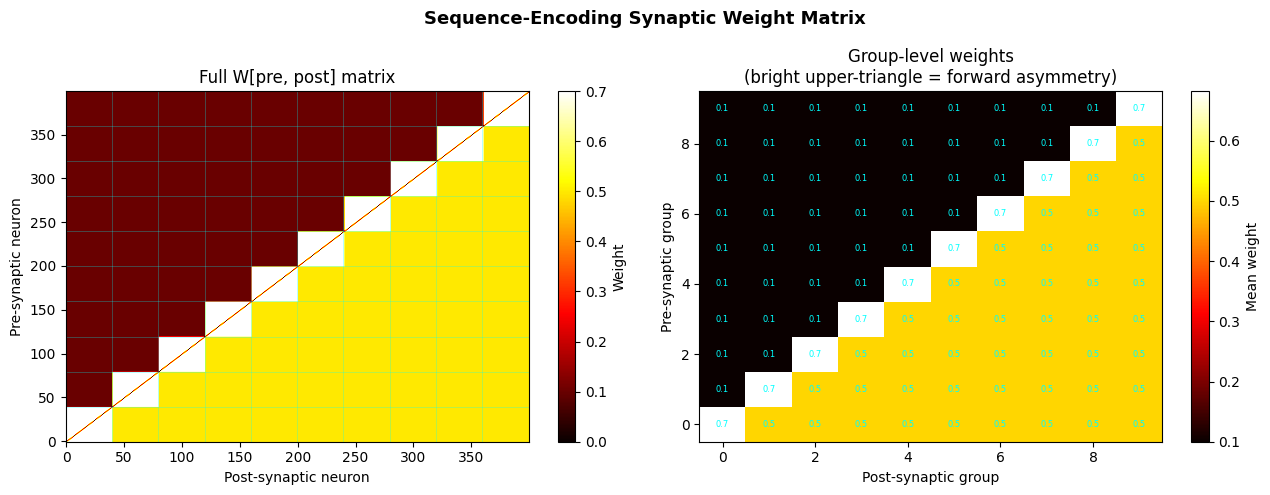

Forward weight: 0.50  |  Backward weight: 0.10
Asymmetry ratio: 5.0x


In [2]:
def build_sequence_weights(w_base=0.5, w_forward=1.5,
                            w_backward=0.1, w_within=0.7):
    """
    Build asymmetric E->E weight matrix encoding a temporal sequence.
    W[pre, post]: weight from pre-synaptic to post-synaptic neuron.
    """
    W = np.ones((N_E, N_E)) * w_base
    np.fill_diagonal(W, 0)
    for pre_g in range(N_GROUPS):
        for post_g in range(N_GROUPS):
            pi = slice(pre_g  * GROUP_SIZE, (pre_g  + 1) * GROUP_SIZE)
            qi = slice(post_g * GROUP_SIZE, (post_g + 1) * GROUP_SIZE)
            if pre_g == post_g:
                W[pi, qi] = w_within
                for k in range(GROUP_SIZE):
                    W[pre_g * GROUP_SIZE + k, post_g * GROUP_SIZE + k] = 0
            elif 0 < post_g - pre_g <= 2:
                W[pi, qi] = w_forward
            elif post_g < pre_g:
                W[pi, qi] = w_backward
    return W


W_EE = build_sequence_weights(w_forward=0.5)

# ── Visualise ─────────────────────────────────────────────────────────────────
group_W = np.zeros((N_GROUPS, N_GROUPS))
for i in range(N_GROUPS):
    for j in range(N_GROUPS):
        group_W[i, j] = W_EE[i*GROUP_SIZE:(i+1)*GROUP_SIZE,
                              j*GROUP_SIZE:(j+1)*GROUP_SIZE].mean()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Sequence-Encoding Synaptic Weight Matrix', fontsize=13, fontweight='bold')

im = axes[0].imshow(W_EE, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(im, ax=axes[0], label='Weight')
for g in range(N_GROUPS + 1):
    axes[0].axhline(g * GROUP_SIZE - 0.5, color='cyan', lw=0.5, alpha=0.4)
    axes[0].axvline(g * GROUP_SIZE - 0.5, color='cyan', lw=0.5, alpha=0.4)
axes[0].set_xlabel('Post-synaptic neuron')
axes[0].set_ylabel('Pre-synaptic neuron')
axes[0].set_title('Full W[pre, post] matrix')

im2 = axes[1].imshow(group_W, cmap='hot', aspect='auto', origin='lower')
plt.colorbar(im2, ax=axes[1], label='Mean weight')
axes[1].set_xlabel('Post-synaptic group')
axes[1].set_ylabel('Pre-synaptic group')
axes[1].set_title('Group-level weights\n(bright upper-triangle = forward asymmetry)')
for i in range(N_GROUPS):
    for j in range(N_GROUPS):
        axes[1].text(j, i, f'{group_W[i,j]:.1f}', ha='center', va='center',
                     color='cyan', fontsize=6)

plt.tight_layout()
plt.savefig('weight_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Forward weight: {group_W[0,1]:.2f}  |  Backward weight: {group_W[1,0]:.2f}')
print(f'Asymmetry ratio: {group_W[0,1]/group_W[1,0]:.1f}x')

## 3. Three-Phase Simulation

- **Encoding (0–450 ms)**: each group receives sequential extra drive, mimicking place cell activation along a track
- **Rest (450–800 ms)**: background drive only, no stimulation
- **Replay (800–860 ms)**: broad Poisson burst to all E neurons (the sharp wave); observe if sequence re-emerges

In [3]:
def simulate_replay(W_EE, seed=42):
    np.random.seed(seed)
    V       = np.random.uniform(V_rest, V_rest + 5.0, N)
    g_E     = np.zeros(N)
    g_I     = np.zeros(N)
    ref_cnt = np.zeros(N, dtype=int)
    p_swr   = SWR_RATE * dt / 1000.0
    sp_t, sp_n = [], []
    LFP = np.zeros(t_steps)

    for step in range(t_steps):
        t = step * dt

        # Spike detection
        fired   = (V >= V_th) & (ref_cnt == 0)
        f_E_idx = np.where(fired[:N_E])[0]
        f_I_idx = np.where(fired[N_E:])[0]
        if fired.any():
            idx = np.where(fired)[0]
            sp_t.extend([t] * len(idx))
            sp_n.extend(idx.tolist())
        V[fired]       = V_reset
        ref_cnt[fired] = t_ref_steps

        # E->E via weight matrix; E->I scalar
        if len(f_E_idx) > 0:
            g_E[:N_E] += W_EE[f_E_idx, :].sum(axis=0)
            g_E[N_E:] += w_EI * len(f_E_idx)
        nI = len(f_I_idx)
        if nI > 0:
            g_I[:N_E] += w_IE * nI
            g_I[N_E:] += w_II * nI

        g_E *= decay_E
        g_I *= decay_I

        # Background
        g_E[:N_E] += w_bg_E * (np.random.random(N_E) < p_bg_E)
        g_E[N_E:] += w_bg_I * (np.random.random(N_I) < p_bg_I)

        # Sequential encoding stimulation
        for g, t_on in enumerate(group_onsets):
            if t_on <= t <= t_on + STIM_DUR:
                g_E[g * GROUP_SIZE:(g+1) * GROUP_SIZE] += STIM_AMP

        # Sharp-wave replay trigger
        if T_SWR_START <= t <= T_SWR_END:
            g_E[:N_E] += w_bg_E * (np.random.random(N_E) < p_swr)

        # Voltage update
        I_net  = g_E - g_I
        dV     = (-(V - V_rest) + I_net) / tau_m * dt
        active = (ref_cnt == 0)
        V[active] += dV[active]
        V = np.clip(V, V_rest - 1, V_th + 1)
        ref_cnt = np.maximum(ref_cnt - 1, 0)
        LFP[step] = g_E[:N_E].mean() - g_I[:N_E].mean()

    return np.array(sp_t), np.array(sp_n), LFP


print('Running three-phase simulation...')
sp_t, sp_n, LFP = simulate_replay(W_EE)
print(f'Done. Total spikes: {len(sp_t)}')
e_rate = float((sp_n < N_E).sum())  / (N_E * dur_s)
i_rate = float((sp_n >= N_E).sum()) / (N_I * dur_s)
print(f'Overall E rate: {e_rate:.1f} Hz  |  I rate: {i_rate:.1f} Hz')

Running three-phase simulation...
Done. Total spikes: 13094
Overall E rate: 13.2 Hz  |  I rate: 56.4 Hz


## 4. Full Simulation Raster

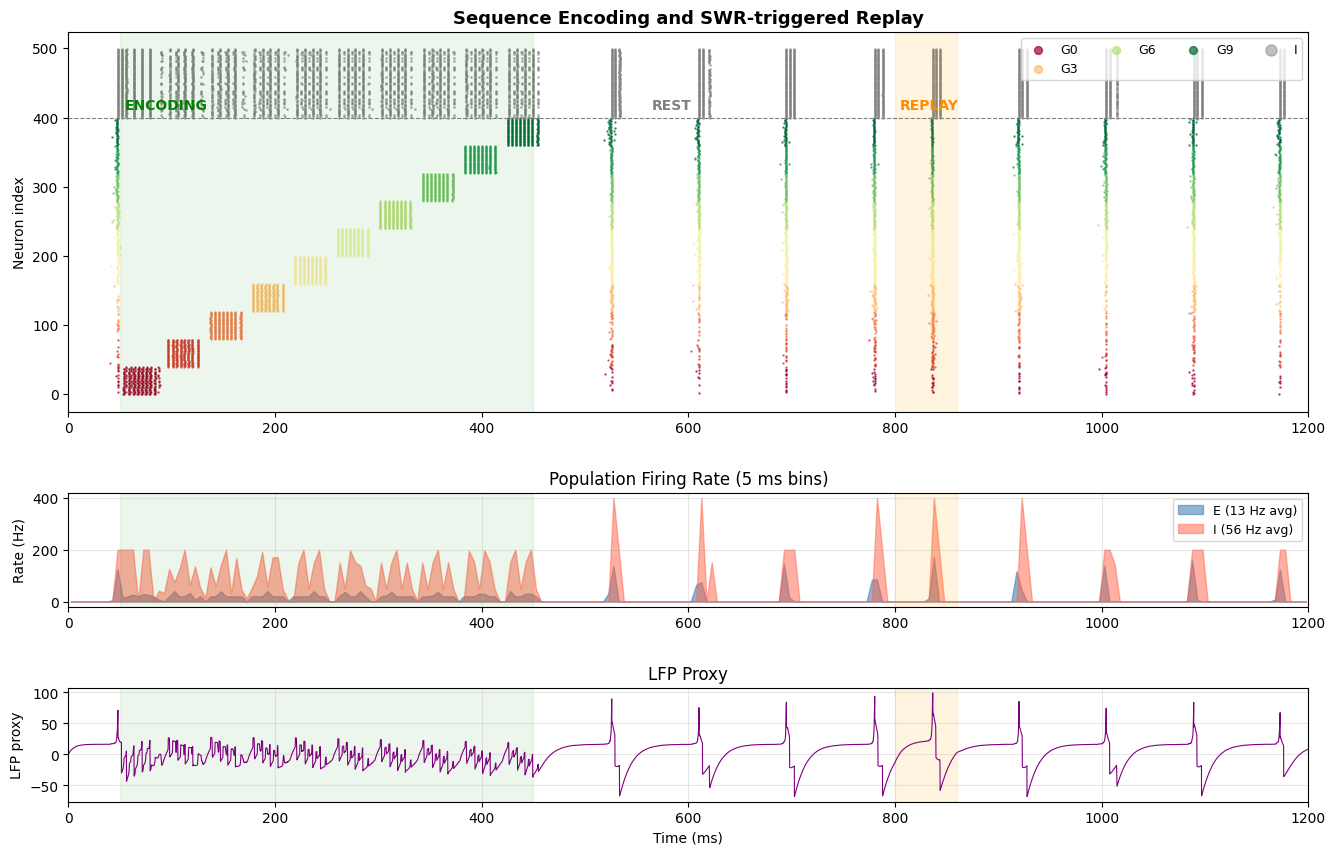

In [4]:
e_mask = sp_n < N_E
i_mask = sp_n >= N_E
group_colors = plt.cm.RdYlGn(np.linspace(0, 1, N_GROUPS))

fig = plt.figure(figsize=(16, 10))
gs  = gridspec.GridSpec(3, 1, height_ratios=[4, 1.2, 1.2], hspace=0.4)

ax0 = fig.add_subplot(gs[0])
for g in range(N_GROUPS):
    gm = e_mask & (sp_n >= g*GROUP_SIZE) & (sp_n < (g+1)*GROUP_SIZE)
    if gm.any():
        ax0.scatter(sp_t[gm], sp_n[gm], s=0.5,
                    color=group_colors[g], alpha=0.7,
                    label=f'G{g}' if g % 3 == 0 else '')
if i_mask.any():
    ax0.scatter(sp_t[i_mask], sp_n[i_mask], s=1.0, color='gray', alpha=0.5, label='I')
ax0.axhline(N_E, color='gray', lw=0.8, linestyle='--')
ax0.axvspan(T_ENC_START, T_ENC_END, alpha=0.07, color='green')
ax0.axvspan(T_SWR_START, T_SWR_END, alpha=0.12, color='orange')
ax0.text(T_ENC_START+5,  N_E+12, 'ENCODING', color='green',  fontsize=10, fontweight='bold')
ax0.text((T_ENC_END+T_SWR_START)/2-60, N_E+12, 'REST', color='gray', fontsize=10, fontweight='bold')
ax0.text(T_SWR_START+5,  N_E+12, 'REPLAY',   color='darkorange', fontsize=10, fontweight='bold')
ax0.set_ylabel('Neuron index')
ax0.set_title('Sequence Encoding and SWR-triggered Replay', fontweight='bold', fontsize=13)
ax0.legend(loc='upper right', markerscale=8, fontsize=9, ncol=4)
ax0.set_xlim(0, T)

# Population rates
bin_ms = 5
bins = np.arange(0, T + bin_ms, bin_ms)
rE, _ = np.histogram(sp_t[e_mask] if e_mask.any() else [], bins=bins)
rI, _ = np.histogram(sp_t[i_mask] if i_mask.any() else [], bins=bins)
rE = rE / (N_E * bin_ms / 1000)
rI = rI / (N_I * bin_ms / 1000)
bc = (bins[:-1] + bins[1:]) / 2

ax1 = fig.add_subplot(gs[1])
ax1.fill_between(bc, rE, alpha=0.6, color='steelblue', label=f'E ({e_rate:.0f} Hz avg)')
ax1.fill_between(bc, rI, alpha=0.5, color='tomato',    label=f'I ({i_rate:.0f} Hz avg)')
ax1.axvspan(T_ENC_START, T_ENC_END, alpha=0.07, color='green')
ax1.axvspan(T_SWR_START, T_SWR_END, alpha=0.12, color='orange')
ax1.set_ylabel('Rate (Hz)'); ax1.set_title('Population Firing Rate (5 ms bins)')
ax1.legend(fontsize=9); ax1.set_xlim(0, T); ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[2])
ax2.plot(t_arr, LFP, color='purple', lw=0.8)
ax2.axvspan(T_ENC_START, T_ENC_END, alpha=0.07, color='green')
ax2.axvspan(T_SWR_START, T_SWR_END, alpha=0.12, color='orange')
ax2.set_ylabel('LFP proxy'); ax2.set_xlabel('Time (ms)')
ax2.set_title('LFP Proxy'); ax2.set_xlim(0, T); ax2.grid(alpha=0.3)

plt.savefig('three_phases.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Zoom: Encoding vs Replay Windows

Colour-coded by group index (red=early, green=late). During faithful replay, the colour gradient should repeat in the same order.

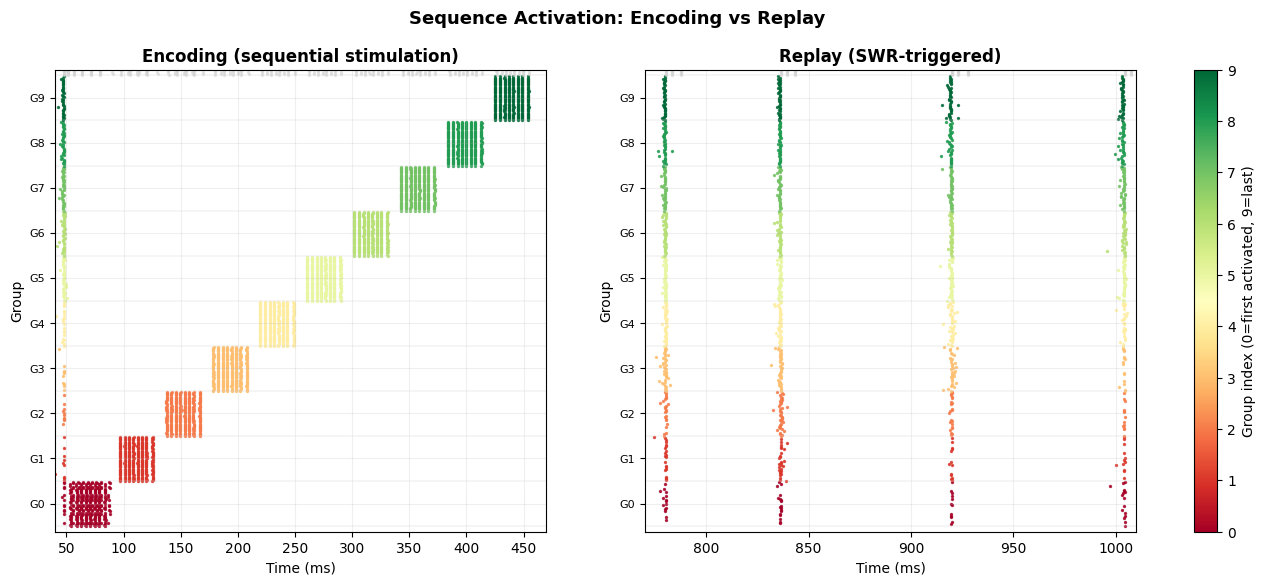

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Sequence Activation: Encoding vs Replay', fontsize=13, fontweight='bold')

windows = [
    ('Encoding (sequential stimulation)', T_ENC_START - 10, T_ENC_END + 20),
    ('Replay (SWR-triggered)', T_SWR_START - 30, min(T_SWR_END + 150, T)),
]
for ax, (title, t0, t1) in zip(axes, windows):
    win = (sp_t >= t0) & (sp_t <= t1)
    for g in range(N_GROUPS):
        gm = win & e_mask & (sp_n >= g*GROUP_SIZE) & (sp_n < (g+1)*GROUP_SIZE)
        if gm.any():
            ax.scatter(sp_t[gm], sp_n[gm], s=2, color=group_colors[g], alpha=0.8)
    iw = win & i_mask
    if iw.any():
        ax.scatter(sp_t[iw], sp_n[iw], s=2, color='lightgray', alpha=0.5)
    for g in range(N_GROUPS + 1):
        ax.axhline(g * GROUP_SIZE, color='lightgray', lw=0.3)
    ax.set_yticks([(g+0.5)*GROUP_SIZE for g in range(N_GROUPS)])
    ax.set_yticklabels([f'G{g}' for g in range(N_GROUPS)], fontsize=8)
    ax.set_xlabel('Time (ms)'); ax.set_ylabel('Group')
    ax.set_title(title, fontweight='bold')
    ax.set_xlim(t0, t1); ax.set_ylim(-5, N_E + 5); ax.grid(alpha=0.2)

sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(0, N_GROUPS-1))
sm.set_array([])
plt.colorbar(sm, ax=axes, label='Group index (0=first activated, 9=last)', fraction=0.02)
plt.savefig('encoding_vs_replay.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Replay Fidelity: Rank-Order Analysis

We compute the mean activation time of each group during encoding and replay,
then measure **Spearman rank correlation**. A positive correlation close to 1
indicates faithful forward replay.

Groups active in encoding: 10 / 10
Groups active in replay:   10 / 10
Spearman r = 0.842, p = 0.0022
=> Significant forward replay detected!


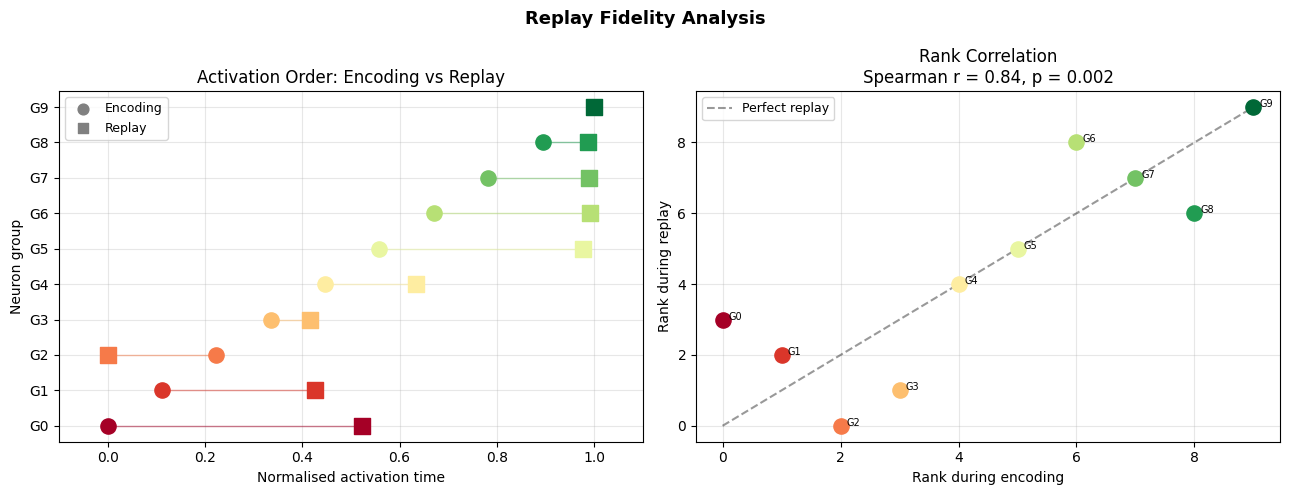

In [6]:
def group_mean_times(sp_t, sp_n, t0, t1):
    mask = (sp_t >= t0) & (sp_t <= t1) & (sp_n < N_E)
    times = []
    for g in range(N_GROUPS):
        gm = mask & (sp_n >= g*GROUP_SIZE) & (sp_n < (g+1)*GROUP_SIZE)
        times.append(sp_t[gm].mean() if gm.any() else np.nan)
    return np.array(times)


enc_times = group_mean_times(sp_t, sp_n, T_ENC_START, T_ENC_END)
rep_times = group_mean_times(sp_t, sp_n, T_SWR_START - 10, T)

valid = ~np.isnan(enc_times) & ~np.isnan(rep_times)
if valid.sum() >= 3:
    corr, pval = spearmanr(enc_times[valid], rep_times[valid])
else:
    corr, pval = np.nan, 1.0

print(f'Groups active in encoding: {(~np.isnan(enc_times)).sum()} / {N_GROUPS}')
print(f'Groups active in replay:   {(~np.isnan(rep_times)).sum()} / {N_GROUPS}')
print(f'Spearman r = {corr:.3f}, p = {pval:.4f}')
if corr > 0.6 and pval < 0.05:
    print('=> Significant forward replay detected!')
elif corr < -0.6 and pval < 0.05:
    print('=> Significant REVERSE replay detected!')
else:
    print('=> No significant replay detected (try increasing w_forward).')

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Replay Fidelity Analysis', fontsize=13, fontweight='bold')

# Activation order comparison
enc_n = (enc_times - np.nanmin(enc_times)) / (np.nanmax(enc_times) - np.nanmin(enc_times) + 1e-9)
rep_n = (rep_times - np.nanmin(rep_times)) / (np.nanmax(rep_times) - np.nanmin(rep_times) + 1e-9)

for g in range(N_GROUPS):
    c = group_colors[g]
    if not np.isnan(enc_n[g]): axes[0].scatter(enc_n[g], g, color=c, s=120, marker='o', zorder=3)
    if not np.isnan(rep_n[g]): axes[0].scatter(rep_n[g], g, color=c, s=120, marker='s', zorder=3)
    if not np.isnan(enc_n[g]) and not np.isnan(rep_n[g]):
        axes[0].plot([enc_n[g], rep_n[g]], [g, g], color=c, lw=1, alpha=0.5)
axes[0].scatter([], [], marker='o', color='gray', s=60, label='Encoding')
axes[0].scatter([], [], marker='s', color='gray', s=60, label='Replay')
axes[0].set_yticks(range(N_GROUPS))
axes[0].set_yticklabels([f'G{g}' for g in range(N_GROUPS)])
axes[0].set_xlabel('Normalised activation time')
axes[0].set_ylabel('Neuron group')
axes[0].set_title('Activation Order: Encoding vs Replay')
axes[0].legend(fontsize=9); axes[0].grid(alpha=0.3); axes[0].set_xlim(-0.1, 1.1)

# Rank scatter
enc_r = np.argsort(np.argsort(enc_times))
rep_r = np.argsort(np.argsort(rep_times))
for g in range(N_GROUPS):
    if not np.isnan(enc_times[g]) and not np.isnan(rep_times[g]):
        axes[1].scatter(enc_r[g], rep_r[g], color=group_colors[g], s=120, zorder=3)
        axes[1].text(enc_r[g]+0.1, rep_r[g], f'G{g}', fontsize=7)
axes[1].plot([0, N_GROUPS-1], [0, N_GROUPS-1], 'k--', lw=1.5, alpha=0.4, label='Perfect replay')
axes[1].set_xlabel('Rank during encoding')
axes[1].set_ylabel('Rank during replay')
axes[1].set_title(f'Rank Correlation\nSpearman r = {corr:.2f}, p = {pval:.3f}')
axes[1].legend(fontsize=9); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('replay_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. How Much Asymmetry is Needed for Faithful Replay?

We vary the forward connection strength and measure replay fidelity.
This is directly analogous to asking: how much STDP-induced weight change
is required to support reliable sequence replay during SWRs?

Scanning weight asymmetry (w_forward)...
  w_fwd=0.5: r=0.85, p=0.002, groups=10/10 **
  w_fwd=0.8: r=0.81, p=0.005, groups=10/10 **
  w_fwd=1.0: r=0.62, p=0.054, groups=10/10 
  w_fwd=1.2: r=0.61, p=0.060, groups=10/10 
  w_fwd=1.5: r=0.58, p=0.082, groups=10/10 
  w_fwd=2.0: r=0.55, p=0.098, groups=10/10 
  w_fwd=3.0: r=-0.37, p=0.293, groups=10/10 


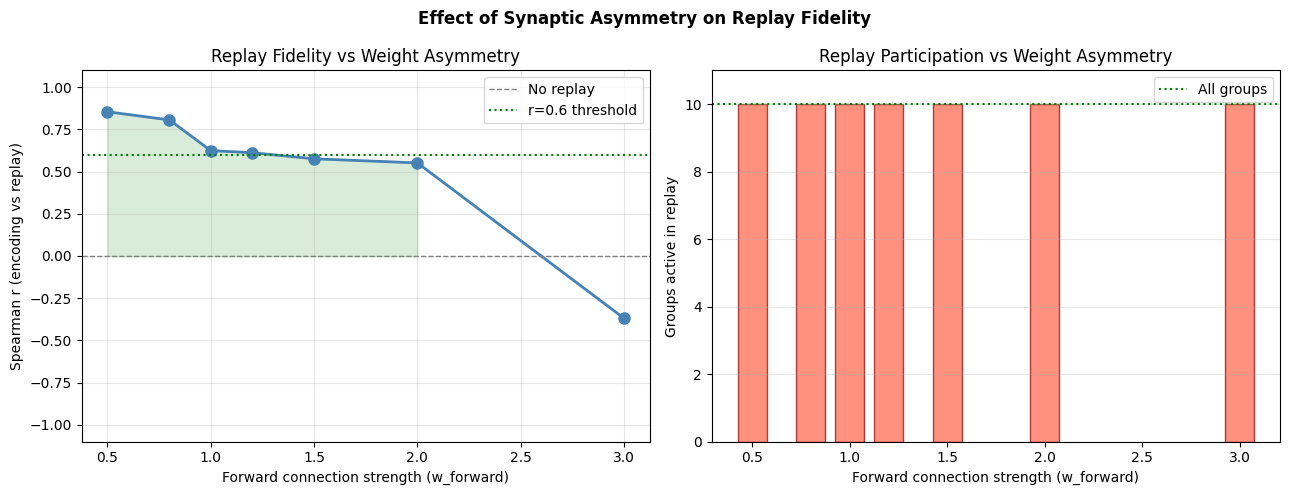

In [7]:
print('Scanning weight asymmetry (w_forward)...')
forward_weights = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 3.0]
results = []

for w_fwd in forward_weights:
    W = build_sequence_weights(w_base=0.5, w_forward=w_fwd,
                                w_backward=0.1, w_within=0.6)
    st, sn, _ = simulate_replay(W, seed=42)
    et = group_mean_times(st, sn, T_ENC_START, T_ENC_END)
    rt = group_mean_times(st, sn, T_SWR_START - 10, T)
    valid = ~np.isnan(et) & ~np.isnan(rt)
    r, p = spearmanr(et[valid], rt[valid]) if valid.sum() >= 3 else (np.nan, 1.0)
    results.append({'w': w_fwd, 'r': r, 'p': p, 'n': valid.sum()})
    sig = '**' if (not np.isnan(r) and p < 0.05) else ''
    print(f'  w_fwd={w_fwd:.1f}: r={r:.2f}, p={p:.3f}, groups={valid.sum()}/{N_GROUPS} {sig}')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Effect of Synaptic Asymmetry on Replay Fidelity',
             fontsize=12, fontweight='bold')

ws = [r['w'] for r in results]
rs = [r['r'] if not np.isnan(r['r']) else 0 for r in results]
ns = [r['n'] for r in results]

axes[0].plot(ws, rs, 'o-', color='steelblue', lw=2, markersize=8)
axes[0].axhline(0,   color='gray',  linestyle='--', lw=1, label='No replay')
axes[0].axhline(0.6, color='green', linestyle=':',  lw=1.5, label='r=0.6 threshold')
axes[0].fill_between(ws, 0, rs, where=[r>0 for r in rs], alpha=0.15, color='green')
axes[0].set_xlabel('Forward connection strength (w_forward)')
axes[0].set_ylabel('Spearman r (encoding vs replay)')
axes[0].set_title('Replay Fidelity vs Weight Asymmetry')
axes[0].set_ylim(-1.1, 1.1); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].bar(ws, ns, width=0.15, color='tomato', alpha=0.7, edgecolor='darkred')
axes[1].axhline(N_GROUPS, color='green', linestyle=':', lw=1.5, label='All groups')
axes[1].set_xlabel('Forward connection strength (w_forward)')
axes[1].set_ylabel('Groups active in replay')
axes[1].set_title('Replay Participation vs Weight Asymmetry')
axes[1].set_ylim(0, N_GROUPS + 1); axes[1].legend(); axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('asymmetry_scan.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

This notebook demonstrated the computational mechanism underlying **hippocampal memory replay**:

1. **Encoding** imprints a temporal sequence via asymmetric Hebbian weights — forward connections are strengthened between neurons that fire in sequence
2. **Replay** emerges when a sharp-wave input triggers a network burst — the asymmetric weight matrix biases activity propagation in the learned forward direction
3. **Replay fidelity** (Spearman r) increases with weight asymmetry — a threshold ratio of forward to backward connections is required for reliable replay
4. **Participation rate** — the fraction of groups active during replay — also depends on synaptic asymmetry, mirroring the ~10-15% CA3 cell participation rate observed in vivo

This notebook provides the computational foundation — the biophysics (Notebook 1), network dynamics (Notebook 2), and replay mechanism (this notebook) — for addressing those questions with the detailed CA3 models the lab develops.

---
## References
- Buzsaki G. (2015). Hippocampal sharp wave-ripple. *Hippocampus* 25(10), 1073-1188.
- Foster & Wilson (2006). Reverse replay of behavioural sequences in hippocampal place cells. *Nature* 440.
- Pfeiffer & Foster (2013). Hippocampal place-cell sequences depict future paths. *Nature* 497.
- Bi & Poo (1998). Synaptic modifications in cultured hippocampal neurons: STDP. *J. Neurosci.* 18.
- Dayan & Abbott (2001). *Theoretical Neuroscience*. MIT Press, Ch. 8.